## 보드 배치 평가 

In [2]:
import os
import glob

image_width, image_height = 640, 480
image_dir= '/home/minkyung/.opticalib/data/251111-DY-ver1/nx'
image_name = 'nx_mono_01.bmp'
image_path = os.path.join(image_dir, image_name)

yaml_path = os.path.join(image_dir, 'result', 'corners_nx_mono_01.yaml')

In [3]:
from itertools import combinations
import math

def cross(o, a, b):
    """ 2D vector cross product. counter-clockwise + """
    return (a[0] - o[0]) * (b[1] - o[1])  - (a[1] - o[1]) * (b[0] - o[0])

def polygon_area(poly):
    """Shoelace: 정점이 반시계(또는 시계) 순서로 주어진 단순 다각형 면적 """
    n = len(poly)
    s = 0.0
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i+1) % n]
        s += x1*y2 - x2*y1
    return abs(s) * 0.5

def angle_sort(points):
    """ 중심을 기준으로 반시계 방향 정렬 """
    cx = sum(p[0] for p in points) / len(points)
    cy = sum(p[1] for p in points) / len(points)
    center = (cx, cy)

    def angle_from_center(p):
        return math.atan2(p[1] - cy, p[0] - cx)

    return sorted(points, key=angle_from_center)

def is_simple_quad(q):
    """ 자기 교차 없는 사각형 판별 """
    def seg_inter(a,b,c,d):
        # 일반 선분 교차 판정(끝점 접촉은 교차로 보지 않음)
        def ccw(p,q,r): return cross(p,q,r)
        
        c1, c2 = ccw(a,b,c), ccw(a,b,d)
        c3, c4 = ccw(c,d,a), ccw(c,d,b)
        if (c1 == 0 and c2 == 0 and c3 == 0 and c4 == 0):
            return False # 공선인 경우 교차로 보지 않음
        return (c1 * c2 < 0) and (c3 * c4 < 0)

    return not seg_inter(q[0], q[1], q[2], q[3]) and not seg_inter(q[1], q[2], q[3], q[0])

def is_convex_polygon(poly):
    """ 모든 연속 3점의 회전 방향이 동일하면 볼록함 """
    n = len(poly)
    s = 0
    for i in range(n):
        o, a, b = poly[i], poly[(i+1)%n], poly[(i+2)%n]
        z = cross(o, a, b)
        if z != 0:
            s = 1 if z > 0 else -1
            break
    if s == 0: # 전부 공선
        return False
    for i in range(n):
        o, a, b = poly[i], poly[(i+1)%n], poly[(i+2)%n]
        if cross(o, a, b) * s < 0:
            return False
    return True

# --- ConvexHull (Monotone Chain)  ---

def convex_hull(points):
    """ 입력: [(x,y),...] 중복 제거 포함. 출력: hull 꼭짓저믈(반시계 순서)"""
    pts = sorted(set(points))
    if len(pts) <= 1:
        return pts

    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
    
    upper = []
    for p in reversed(pts):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)
    
    hull = lower[:-1] + upper[:-1]
    return hull

# --- Maximum Area Search ---
def max_area_quadrilateral(points):
    """ 단순하고 볼록한 사각형 중 최대 면적 찾기 
    Returns: (max_area, [v0, v1, v2, v3]) - 반시계 순서 
    """
    if len(points) < 4:
        return 0.0, []
    
    hull = convex_hull(points)
    h = len(hull)
    if h < 3:
        return 0.0, []
    
    best_area = 0.0
    best_quad = []

    # hull 에서 4점 조합 검사 
    for a, b, c, d in combinations(range(h), 4):
        quad = [hull[a], hull[b], hull[c], hull[d]]
        
        # 정점 순서를 중심 기준 각도 순으로 정렬 
        quad = angle_sort(quad)
        
        # 단순/볼록 체크
        if not is_simple_quad(quad):
            continue
        if not is_convex_polygon(quad):
            continue
        area = polygon_area(quad)
        if area > best_area:
            best_area, best_quad = area, quad

    return best_area, best_quad


In [4]:
import yaml

def load_corners2d_from_yaml(path):
    with open(path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)
    
    # data: list[ dict ]
    if not isinstance(data, list):
        raise TypeError("YAML top-level must be a list for this simplified loader.")
    corners2d = None
    for item in data:
        if isinstance(item, dict) and "corners2d" in item:
            corners2d = item["corners2d"]
            break
    if corners2d is None:
        raise KeyError("corners2d not found in YAML List.")
    
    return [(float(x), float(y)) for (x, y) in corners2d]

In [5]:
yaml_path

'/home/minkyung/.opticalib/data/251111-DY-ver1/nx/result/corners_nx_mono_01.yaml'

In [6]:
image_path

'/home/minkyung/.opticalib/data/251111-DY-ver1/nx/nx_mono_01.bmp'

In [7]:
pts = load_corners2d_from_yaml(yaml_path)
area, quad = max_area_quadrilateral(pts)
print("Max Area:", area)
print(f"points: {len(pts)}")

Max Area: 1249928.518214534
points: 40


In [8]:
import cv2
import numpy as np

def draw_quad(image, quad, color=(0, 255, 0), thickness=2):
    """주어진 4각형 좌표를 따라 선을 그려주는 헬퍼 함수"""
    if not quad:
        return image

    pts_arr = np.array(quad, dtype=np.int32).reshape(-1, 1, 2)
    cv2.polylines(image, [pts_arr], isClosed=True, color=color, thickness=thickness)
    return image


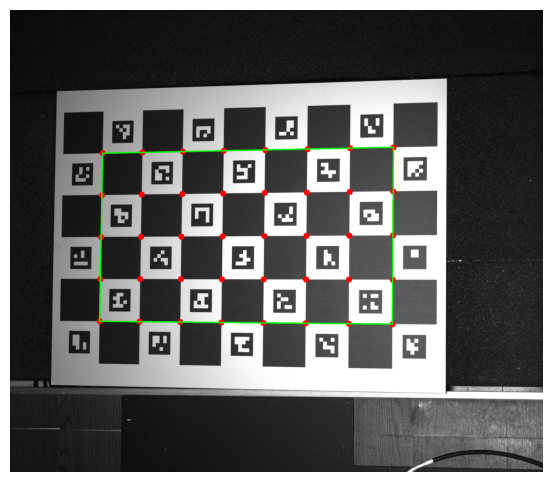

In [14]:
import matplotlib.pyplot as plt

if not os.path.exists(image_path):
    raise FileNotFoundError(f'이미지 경로를 찾을 수 없습니다: {image_path}')

image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if image is None:
    raise ValueError(f'cv2.imread가 이미지를 불러오지 못했습니다: {image_path}')

vis = image.copy()
for x, y in pts:
    cv2.circle(vis, (int(round(x)), int(round(y))), radius=15, color=(0, 0, 255), thickness=-1)

vis = draw_quad(vis, quad, color=(0, 255, 0), thickness=5)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
